# Transformer

`Transformer`是2017年推出的一种利用注意力机制的深度学习模型。它主要用于自然语言处理(NLP)领域，但最近的研究也将其应用于其他任务，如视频理解。

在本文档中，我们将看到如何使用`e3nn`实现等变注意机制。

我们将实现公式(1)的SE(3)-Transformers。输出特征f'，由
$$\begin{array}{r}
f_i^{\prime}=\sum_{j=1}^n \alpha_{i j} v_j \\
\alpha_{i j}=\frac{\exp \left(q_i^T k_j\right)}{\sum_{j^{\prime}=1}^n \exp \left(q_i^T k_{j^{\prime}}\right)}
\end{array}$$

其中$q,k,v$分别称为查询，键和值。它们是输入特征$f$的函数。

$$\begin{aligned}
q & =h_Q(f) \\
k & =h_K(f) \\
v & =h_V(f)
\end{aligned}$$

所有这些公式在同一篇文章的图(2)中得到了很好的说明。

![](images/11.png)


首先，我们需要定义输入、查询、键和输出的副本。注意，输出和值共享相同的$irreps$。

In [10]:
import torch
from torch_cluster import radius_graph
from torch_scatter import scatter
from e3nn import o3, nn
from e3nn.math import soft_one_hot_linspace, soft_unit_step
import matplotlib.pyplot as plt

In [5]:
# Just define arbitrary irreps
irreps_input = o3.Irreps("10x0e + 5x1o + 2x2e")
irreps_query = o3.Irreps("11x0e + 4x1o")
irreps_key = o3.Irreps("12x0e + 3x1o")
irreps_output = o3.Irreps("14x0e + 6x1o")  # also irreps of the values

让我们创建一个可以应用注意力机制的随机图

In [6]:
num_nodes = 20

pos = torch.randn(num_nodes, 3)
f = irreps_input.randn(num_nodes, -1)

# create graph
max_radius = 1.3
edge_src, edge_dst = radius_graph(pos, max_radius)
edge_vec = pos[edge_src] - pos[edge_dst]
edge_length = edge_vec.norm(dim=1)

查询$q_i$是输入特征$f_i$的线性组合。

In [7]:
h_q = o3.Linear(irreps_input, irreps_query)

/DYZ/dyz1/anaconda3/envs/gnn/lib/python3.8/site-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


为了生成依赖于半径的权重，我们在一个基础上投影边的长度

In [9]:
number_of_basis = 10
edge_length_embedded = soft_one_hot_linspace(
    edge_length,
    start=0.0,
    end=max_radius,
    number=number_of_basis,
    basis='smooth_finite',
    cutoff=True  # goes (smoothly) to zero at `start` and `end`
)
edge_length_embedded = edge_length_embedded.mul(number_of_basis**0.5)

我们还需要一个介于0和1之间的数字来平滑地表示如果边的长度小于`max_radius`

In [11]:
edge_weight_cutoff = soft_unit_step(10 * (1 - edge_length / max_radius))

这是使用的函数图

为了创建值和键，我们必须使用边缘的相对位置。我们将使用球面谐波对相对位置有更丰富的描述

In [12]:
irreps_sh = o3.Irreps.spherical_harmonics(3)
edge_sh = o3.spherical_harmonics(irreps_sh, edge_vec, True, normalization='component')

我们将在输入和球面谐波之间做一个张量积来创建值和键。因为我们想要这些张量积的权重依赖于边的长度，我们将使用多层感知器生成权重。

In [13]:
tp_k = o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_key, shared_weights=False)
fc_k = nn.FullyConnectedNet([number_of_basis, 16, tp_k.weight_numel], act=torch.nn.functional.silu)

tp_v = o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_output, shared_weights=False)
fc_v = nn.FullyConnectedNet([number_of_basis, 16, tp_v.weight_numel], act=torch.nn.functional.silu)

/DYZ/dyz1/anaconda3/envs/gnn/lib/python3.8/site-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


对于公式的对应，$tp_v, fc_v$表示$h_k$, $tp_v, fc_v$表示$h_v$。然后我们需要一种方法来计算查询和键之间的点积

In [14]:
dot = o3.FullyConnectedTensorProduct(irreps_query, irreps_key, "0e")

`tp_k, tp_v`和`dot`

![](./images/22.png)

最后，我们可以使用我们创建的所有模块来计算注意力机制

In [15]:
# compute the queries (per node), keys (per edge) and values (per edge)
q = h_q(f)
k = tp_k(f[edge_src], edge_sh, fc_k(edge_length_embedded))
v = tp_v(f[edge_src], edge_sh, fc_v(edge_length_embedded))

# compute the softmax (per edge)
exp = edge_weight_cutoff[:, None] * dot(q[edge_dst], k).exp()  # compute the numerator
z = scatter(exp, edge_dst, dim=0, dim_size=len(f))  # compute the denominator (per nodes)
z[z == 0] = 1  # to avoid 0/0 when all the neighbors are exactly at the cutoff
alpha = exp / z[edge_dst]

# compute the outputs (per node)
f_out = scatter(alpha.relu().sqrt() * v, edge_dst, dim=0, dim_size=len(f))

请注意，该实现与本文略有不同。
- 当我们移动点（删除/创建新的边缘）时，请特别注意使整个操作变得平稳。它是通过`edge_weight_cutoff, edge_length_embedded`和径向神经网络的属性`f(0)=0`来完成的。
- 输出的权重为$\sqrt{\alpha_{i j}}$代替$\alpha_{i j}$以确保适当的正则化。

下面从归一化开始，对两者进行检查。



In [16]:
f_out.mean().item(), f_out.std().item()

(-0.09971921145915985, 0.9955587387084961)

我们把所有的东西都放到一个函数里来检验平滑性和等方差。

In [17]:
def transformer(f, pos):
    edge_src, edge_dst = radius_graph(pos, max_radius)
    edge_vec = pos[edge_src] - pos[edge_dst]
    edge_length = edge_vec.norm(dim=1)

    edge_length_embedded = soft_one_hot_linspace(
        edge_length,
        start=0.0,
        end=max_radius,
        number=number_of_basis,
        basis='smooth_finite',
        cutoff=True
    )
    edge_length_embedded = edge_length_embedded.mul(number_of_basis**0.5)
    edge_weight_cutoff = soft_unit_step(10 * (1 - edge_length / max_radius))

    edge_sh = o3.spherical_harmonics(irreps_sh, edge_vec, True, normalization='component')

    q = h_q(f)
    k = tp_k(f[edge_src], edge_sh, fc_k(edge_length_embedded))
    v = tp_v(f[edge_src], edge_sh, fc_v(edge_length_embedded))

    exp = edge_weight_cutoff[:, None] * dot(q[edge_dst], k).exp()
    z = scatter(exp, edge_dst, dim=0, dim_size=len(f))
    z[z == 0] = 1
    alpha = exp / z[edge_dst]

    return scatter(alpha.relu().sqrt() * v, edge_dst, dim=0, dim_size=len(f))

这是一个平滑检查:两个节点被放置在距离为1的地方(`max_radius > 1`)，这样它们就可以看到彼此。来自远方的第三个节点慢慢地向它们移动。

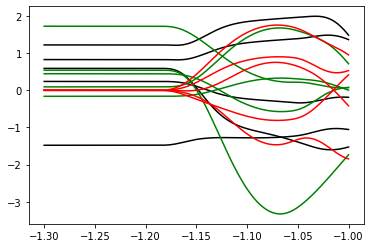

In [18]:
f = irreps_input.randn(3, -1)

xs = torch.linspace(-1.3, -1.0, 200)
outputs = []

for x in xs:
    pos = torch.tensor([
        [0.0, 0.5, 0.0],       # this node always sees...
        [0.0, -0.5, 0.0],      # ...this node
        [x.item(), 0.0, 0.0],  # this node moves slowly
    ])

    with torch.no_grad():
        outputs.append(transformer(f, pos))

outputs = torch.stack(outputs)
plt.plot(xs, outputs[:, 0, [0, 1, 14, 15, 16]], 'k')  # plots 2 scalars and 1 vector
plt.plot(xs, outputs[:, 1, [0, 1, 14, 15, 16]], 'g')
plt.plot(xs, outputs[:, 2, [0, 1, 14, 15, 16]], 'r')

最后我们可以检查一下等方差

In [19]:
f = irreps_input.randn(10, -1)
pos = torch.randn(10, 3)

rot = o3.rand_matrix()
D_in = irreps_input.D_from_matrix(rot)
D_out = irreps_output.D_from_matrix(rot)

f_before = transformer(f @ D_in.T, pos @ rot.T)
f_after = transformer(f, pos) @ D_out.T

torch.allclose(f_before, f_after, atol=1e-3, rtol=1e-3)

True

对向后传递进行额外的完整性检查

In [20]:
for x in [0.0, 1e-6,  max_radius / 2, max_radius - 1e-6, max_radius, max_radius + 1e-6, 2 * max_radius]:
    f = irreps_input.randn(2, -1, requires_grad=True)
    pos = torch.tensor([
        [0.0, 0.0, 0.0],
        [x, 0.0, 0.0],
    ], requires_grad=True)
    transformer(f, pos).sum().backward()

    assert f.grad is None or torch.isfinite(f.grad).all()
    assert torch.isfinite(pos.grad).all()